# Comparando algoritmos sencillos - Supervisados
*Datos no estandarizados*

En este notebook vamos a utilizar los datos pre-procesados para entrenar varios algoritmos, sin estandarizarlos. Compararemos su rendimiento utilizando algunas métricas númericas y plots.

## Preparamos la data

In [1]:
# Importamos las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Cargamos los dataframe con los datos pre-procesados.
Los datos fueron generados con [el script preprocesamiento.py](https://github.com/marianaiv/benchmark_clalgoritmos/tree/preprocesamiento/scripts)

In [2]:
# Importamos los datos
datos = ['../data/RD_GBC_0', '../data/RD_GBC_1', '../data/RD_GBC_2', '../data/RD_GBC_3', '../data/RD_GBC_4',
        '../data/RD_GBC_5', '../data/RD_GBC_6', '../data/RD_GBC_7', '../data/RD_GBC_8', '../data/RD_GBC_9']
df = pd.DataFrame()

for path in datos:
    df_i = pd.read_csv(path)
    df = pd.concat([df, df_i])

df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrones_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrones_j2,m_jj,deltaR_j12,n_hadrones,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,170.076344,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,1053.333258,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,759.634459,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,691.631325,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,284.861613,3.629229,169.0,1.0


In [3]:
# Definimos una función para separar un dataframe en caracteristicas y label

from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None  # default='warn'

def data_ready(df, label='label'):
    
    # Creamos una lista con las características a considerar en el modelo
    carac_cols = df.columns.values.tolist()
    
    # Eliminamos 'label' porque no es una característica
    carac_cols.remove(label)

    # Hacemos un dataframe solo con las características
    X = df[carac_cols]
    
    # Eliminamos la estandarizacion
    '''
    # Normalizamos los datos
    for column in list(X.columns):
        feature = np.array(X[column]).reshape(-1,1)
        scaler = MinMaxScaler()
        scaler.fit(feature)
        feature_scaled = scaler.transform(feature)
        X[column] = feature_scaled.reshape(1,-1)[0]
    '''

    # Obtenemos la serie con la información sobre señal o fondo
    y = df[label]
    
    return X, y

Separamos la tabla en dos: una con las características y otra con los labels. Luego, creamos un conjunto de entrenamiento y uno de prueba

In [4]:
# Separamos los datos en conjuntos de entrenamiento y prueba
df_RD = df.sample(100000, random_state = 1)
X, y = data_ready(df_RD)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% entrenamiento y 30% prueba

## Métricas
Como vamos a probar distintos clasificadores, necesitamos valores númericos que nos permitan evaluar el rendimiento de los algoritmos. Algunos valores de utilidad son:

### Matriz de confusión

Una matriz de confusión es una herramienta que permite visualizar el desempeño de un algoritmo de aprendizaje supervisado. Los elementos diagonales representan el número de puntos para los cuales la etiqueta predicha es igual a la etiqueta verdadera, mientras que los elementos fuera de la diagonal son aquellos que están mal etiquetados por el clasificador. Cuanto más altos sean los valores diagonales de la matriz de confusión, mejor, lo que indica muchas predicciones correctas.

![](https://i.imgur.com/wi89FjN.png)

Donde:
- **TP**: True positive
- **FP**: False positive
- **FN**: False negative
- **TN**: True negative

### Exactitud
Es el numero de predicciones correctas hechas por el modelo sobre todo el tipo de predicciones hechas:
$$ 
\text{Exactitud} = \frac{TP+TN}{TP+FP+FN+TN}
$$

Esta es una buena medida cuando las clases en los datos están bien balanceadas. No se debe usar como medida cuando las clases de variables de destino en los datos son la mayoría de una clase.

### Precisión
Indica la proporcion de verdaderos positivos, en nuestro caso, qué proporción de señal etiquetada por el modelo como señal es verdaderamente señal:
$$
\text{Precision} = \frac{TP}{TP+FP}
$$

La precisión nos da información acerca del rendimiento del clasificador respecto a falsos positivos, cuantos atrapó.

### Sensibilidad o Recuperación
En nuestro caso, indica la proporcion de señal fue etiquetada éxitosamente como señal:
$$
\text{Sensibilidad} = \frac{TP}{TP+FN}
$$
Donde:
- La señal real es TP y FN
- La fracción de señal predicha por el modelo es TP

La sensibilidad nos da información sobre el rendimiento del clasificador respecto a los falsos negativos, cuantos falló.

### Especificidad
Es la medida que nos indica la proporcion de fondo que fue predicha por el modelo como fondo. Los negativos (los datos que en realidad son fondo son FP y TN) y el fondo segun el modelo (TN):
$$ 
\text{Especificidad} = \frac{TN}{TN+FP}
$$

La especificidad es el opuesto a la sensibilidad.

### Puntaje F1
Es la media harmónica entre la precision y la sensibilidad. Se puede interpretar como un promedio ponderado de la precisión y la sensibilidad, donde un puntaje F1 alcanza su mejor valor en 1 y el peor puntaje en 0. La contribución relativa de precisión y recuperación a la puntuación F1 son iguales.
$$
F1 = 2\frac{\text{precision}\times\text{sensibilidad}}{\text{precicion}+\text{sensibilidad}}
$$

### Pérdida Logarítmica
Funciona penalizando la clasificación errada. Supongamos N muestras en M clases:
$$
LL = \frac{-1}{N}\sum^N_{i=1}\sum^M_{j=1}y_{ij}*\text{log}(p_ij)
$$
Donde:
- $y_{ij}$ indica si la muestra pertenece a la clase *i* o *j* o no
- $p_{ij}$ indica la probabilidad de que la muestra a la clase *i* pertenezca a la clase *j*.

La pérdida logarítmica no tiene límite superior. Una pérdida logarítimica cerca de 0 indica mayor exactitud. En general, minimizar la pérdida logarítmica aumenta la exactitud del clasificador.

## Clasificadores
Vamos a iterar sobre una lista de clasificadores, para obtener métricas que nos permitan comparar el rendimiento de cada algoritmo. Utilizaremos `sklearn.metrics`.

C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression
****Resultados****
Precisión: 69.6827%
Pérdida logaritmica: 0.1704
              precision    recall  f1-score   support

       fondo       0.95      0.98      0.96     27297
       señal       0.70      0.44      0.54      2703

    accuracy                           0.93     30000
   macro avg       0.82      0.71      0.75     30000
weighted avg       0.92      0.93      0.93     30000



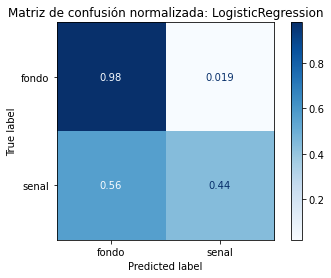

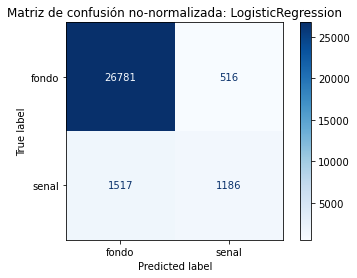

KNeighborsClassifier
****Resultados****
Precisión: 76.4729%
Pérdida logaritmica: 0.7203
              precision    recall  f1-score   support

       fondo       0.97      0.98      0.98     27297
       señal       0.76      0.72      0.74      2703

    accuracy                           0.95     30000
   macro avg       0.87      0.85      0.86     30000
weighted avg       0.95      0.95      0.95     30000



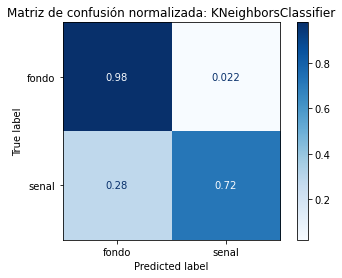

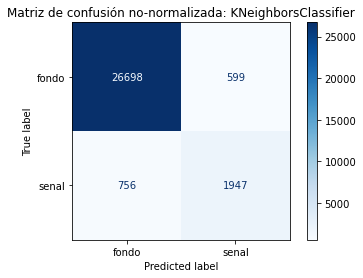

SVC
****Resultados****


C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.p

Precisión: 0.0000%
Pérdida logaritmica: 0.1497
              precision    recall  f1-score   support

       fondo       0.91      1.00      0.95     27297
       señal       0.00      0.00      0.00      2703

    accuracy                           0.91     30000
   macro avg       0.45      0.50      0.48     30000
weighted avg       0.83      0.91      0.87     30000



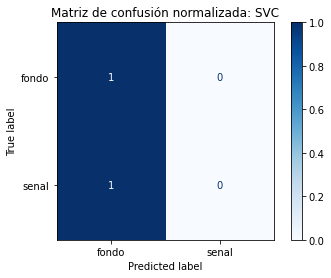

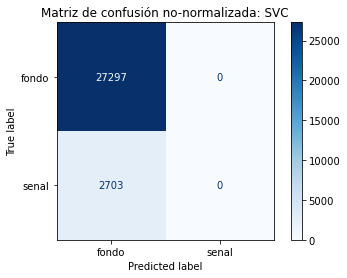

DecisionTreeClassifier
****Resultados****
Precisión: 76.8604%
Pérdida logaritmica: 0.1601
              precision    recall  f1-score   support

       fondo       0.95      0.98      0.97     27297
       señal       0.77      0.52      0.62      2703

    accuracy                           0.94     30000
   macro avg       0.86      0.75      0.80     30000
weighted avg       0.94      0.94      0.94     30000



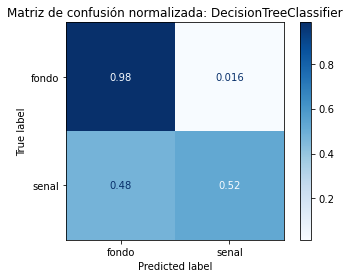

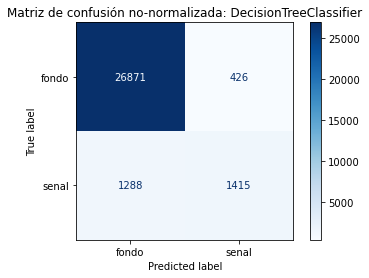

RandomForestClassifier
****Resultados****
Precisión: 92.8899%
Pérdida logaritmica: 0.1121
              precision    recall  f1-score   support

       fondo       0.98      0.99      0.98     27297
       señal       0.93      0.75      0.83      2703

    accuracy                           0.97     30000
   macro avg       0.95      0.87      0.91     30000
weighted avg       0.97      0.97      0.97     30000



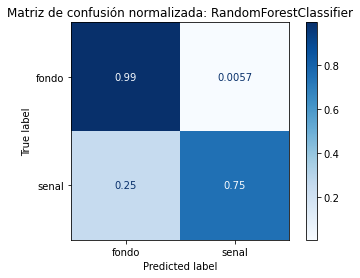

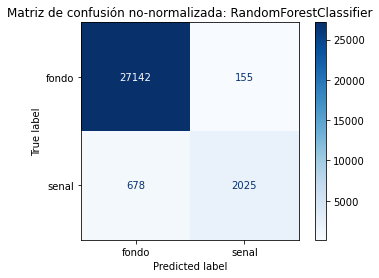

AdaBoostClassifier
****Resultados****
Precisión: 83.6243%
Pérdida logaritmica: 0.6401
              precision    recall  f1-score   support

       fondo       0.97      0.99      0.98     27297
       señal       0.84      0.74      0.79      2703

    accuracy                           0.96     30000
   macro avg       0.91      0.86      0.88     30000
weighted avg       0.96      0.96      0.96     30000



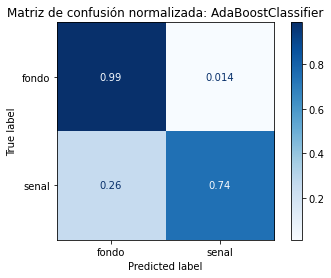

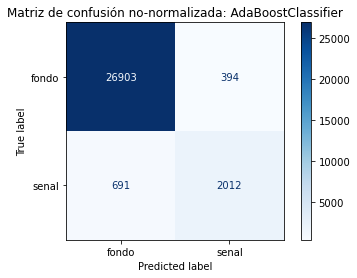

GradientBoostingClassifier
****Resultados****
Precisión: 89.9645%
Pérdida logaritmica: 0.08781
              precision    recall  f1-score   support

       fondo       0.98      0.99      0.98     27297
       señal       0.90      0.75      0.82      2703

    accuracy                           0.97     30000
   macro avg       0.94      0.87      0.90     30000
weighted avg       0.97      0.97      0.97     30000



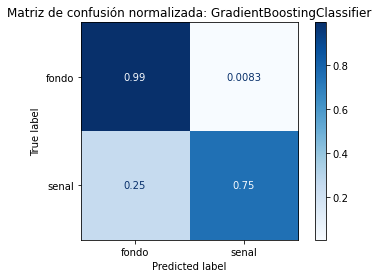

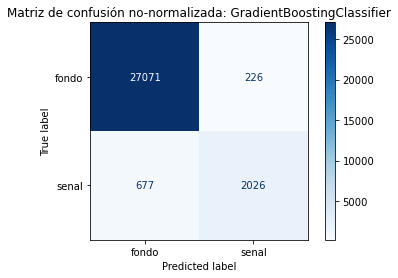

GaussianNB
****Resultados****
Precisión: 56.3259%
Pérdida logaritmica: 0.2632
              precision    recall  f1-score   support

       fondo       0.98      0.94      0.96     27297
       señal       0.56      0.77      0.65      2703

    accuracy                           0.93     30000
   macro avg       0.77      0.86      0.80     30000
weighted avg       0.94      0.93      0.93     30000



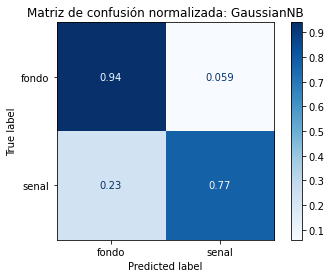

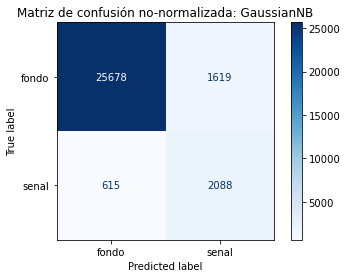

LinearDiscriminantAnalysis
****Resultados****
Precisión: 65.7853%
Pérdida logaritmica: 0.1728
              precision    recall  f1-score   support

       fondo       0.96      0.97      0.97     27297
       señal       0.66      0.61      0.63      2703

    accuracy                           0.94     30000
   macro avg       0.81      0.79      0.80     30000
weighted avg       0.93      0.94      0.94     30000



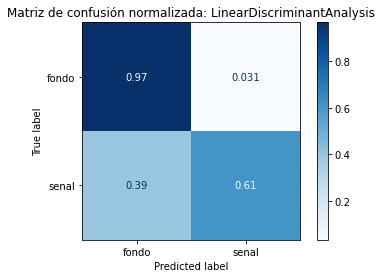

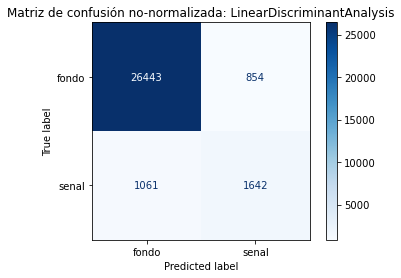

C:\Users\maria\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis
****Resultados****
Precisión: 57.4141%
Pérdida logaritmica: 0.2325
              precision    recall  f1-score   support

       fondo       0.98      0.94      0.96     27297
       señal       0.57      0.83      0.68      2703

    accuracy                           0.93     30000
   macro avg       0.78      0.88      0.82     30000
weighted avg       0.95      0.93      0.93     30000



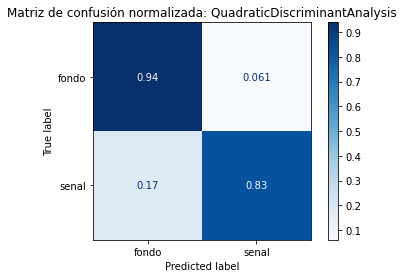

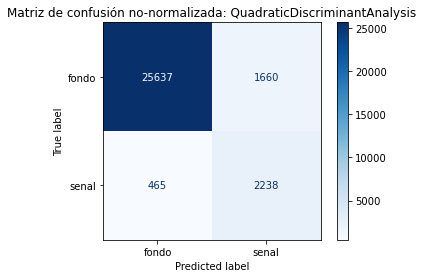

MLPClassifier
****Resultados****
Precisión: 59.0059%
Pérdida logaritmica: 0.2419
              precision    recall  f1-score   support

       fondo       0.98      0.94      0.96     27297
       señal       0.59      0.82      0.69      2703

    accuracy                           0.93     30000
   macro avg       0.79      0.88      0.82     30000
weighted avg       0.95      0.93      0.94     30000



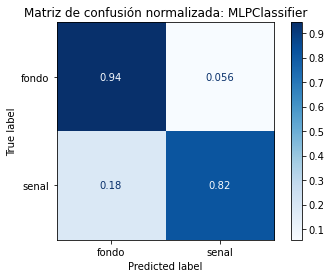

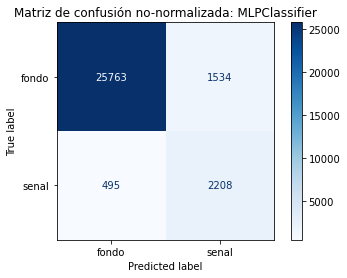

In [5]:
# Importamos las métricas a utilizar
from sklearn.metrics import precision_score, log_loss, recall_score, plot_confusion_matrix,classification_report, f1_score

# Importamos los clasificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


# Listamos los clasificadores a comparar
clasificadores = [LogisticRegression(max_iter=600),
                KNeighborsClassifier(3, weights='distance'),
                SVC(kernel="rbf", C=0.025, probability=True),
                DecisionTreeClassifier(criterion="entropy", max_depth=3),
                RandomForestClassifier(),
                AdaBoostClassifier(),
                GradientBoostingClassifier(),
                GaussianNB(),
                LinearDiscriminantAnalysis(),
                QuadraticDiscriminantAnalysis(), 
                MLPClassifier()]

# Registro para comparación visual
log_cols=["Clasificador", "Precision", "Perdida Log", "puntaje f1"]
log = pd.DataFrame(columns=log_cols)

for clf in clasificadores:
    
    # Entrenamos el clasificador y obtenemos su nombre
    clf.fit(X_train, y_train)
    nombre = clf.__class__.__name__
    
    print("="*30)
    print(nombre)
    
    print('****Resultados****')
    
    # Obtenemos las predicciones
    y_pre = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    # Calculamos algunas métricas
    precision = precision_score(y_test, y_pre)
    print("Precisión: {:.4%}".format(precision))
    
    ll = log_loss(y_test, y_proba)
    print("Pérdida logaritmica: {:.4}".format(ll))
    
    f1 = f1_score(y_test, y_pre)
    
    # Imprimimos el reporte general
    print(classification_report(y_test, y_pre, target_names=['fondo','señal']))
    
    # Insertamos los datos en el dataframe
    log_entry = pd.DataFrame([[nombre, precision*100, ll, f1]], columns=log_cols)
    log = log.append(log_entry)
    
    # Graficamos la matriz de confusión
    
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['fondo','senal'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    
    disp.ax_.set_title("Matriz de confusión normalizada: {}".format(nombre))

    plt.show()
    
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['fondo','senal'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    
    disp.ax_.set_title("Matriz de confusión no-normalizada: {}".format(nombre))

    plt.show()
    
print("="*30)

Ahora comparamos algunas de las métricas simultáneamente para todos los algoritmos:

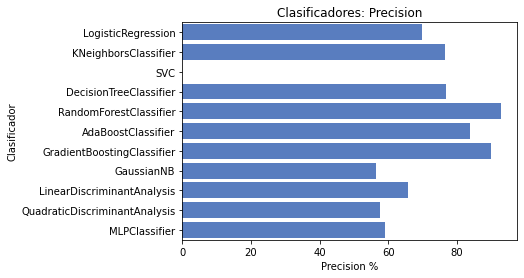

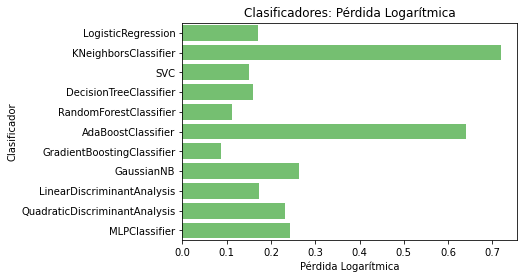

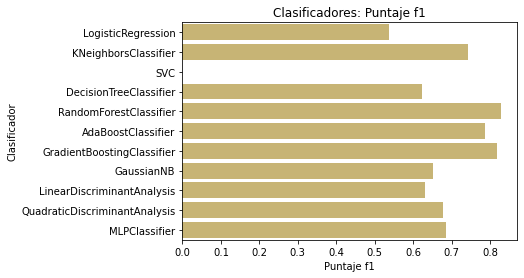

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Clasificador', data=log, color="b")
plt.xlabel('Precision %')
plt.title('Clasificadores: Precision')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Perdida Log', y='Clasificador', data=log, color="g")
plt.xlabel('Pérdida Logarítmica')
plt.title('Clasificadores: Pérdida Logarítmica')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='puntaje f1', y='Clasificador', data=log, color="y")
plt.xlabel('Puntaje f1')
plt.title('Clasificadores: Puntaje f1')
plt.show()

De estas métricas podemos ver que los algoritmos con menor pérdida logaritmica y mayor precisión y puntaje f1 son:
- Random Forest
- Gradient Boosting
- Ada Boost

## Curva ROC y AUC
Es una métrica de rendimiento de los clasificadores para varios ajustes de umbral que se usa mayormente en clasificadores binarios. ROC es la curva de probabilidad y el area bajo la curva (AUC) representa el grado o medida de separabilidad. Nos dice cuánto el módelo es capaz de distinguir entre clases.

La decisión de convertir una probabilidad predicha o una puntuación en una etiqueta de clase se rige por un parámetro denominado "umbral de decisión", "umbral de discriminación" o simplemente "umbral". 

El valor predeterminado para el umbral es 0.5 para probabilidades normalizadas o puntuaciones en el rango entre 0 o 1. 

Por ejemplo, en un problema de clasificación binaria con etiquetas de clase 0 y 1, probabilidades predichas normalizadas y un umbral de 0,5, los valores inferiores al umbral de 0,5 se asignan a la clase 0 y los valores superiores o iguales a 0,5 se asignan a la clase 1:

$$Predicción < 0.5  \implies \text{Clase 0}$$

$$Predicción> = 0.5 \implies \text{Clase 1}$$

El problema es que el umbral predeterminado puede no representar una interpretación óptima de las probabilidades predichas.

La **curva ROC** se obtiene variando este umbral y graficando *sensibilidad vs. 1-especificidad*, o la *tasa de verdaderos positivos vs. la tasa de falsos positivos*.

El **AUC** es el área bajo la curva, que mientras mayor sea, mejor es el modelo distinguiendo clases.

Para hacer la curva ROC y calcular AUC, definimos los clasificadores, los entrenamos y realizamos las predicciones:

In [7]:
# https://stackoverflow.com/questions/52373318/how-to-compare-roc-auc-scores-of-different-binary-classifiers-and-assess-statist
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib

#MLP Classifier
mlp_clf = MLPClassifier(max_iter=400)
mlp_clf.fit(X_train, y_train)
mlp_prediccion_proba = mlp_clf.predict_proba(X_test)[:, 1]
mlp_nombre = mlp_clf.__class__.__name__


# Random Forest 
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_prediccion_proba = rf_clf.predict_proba(X_test)[:, 1]
rf_nombre = rf_clf.__class__.__name__

# Gradient Boosting
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
gb_prediccion_proba = gb_clf.predict_proba(X_test)[:, 1]
gb_nombre = gb_clf.__class__.__name__

Definimos una función que funcione para obtener la tasa de falsos y verdaderos positivos.

In [8]:
def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

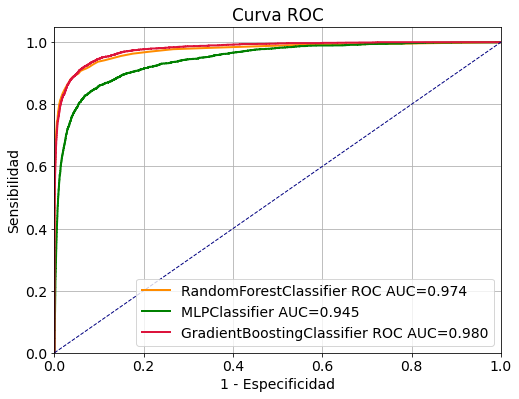

In [9]:
plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, rf_prediccion_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='{} ROC AUC={:.3f}'.format(rf_nombre, roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, mlp_prediccion_proba)
plt.plot(fpr, tpr, color='green', lw=2,
         label='{} AUC={:.3f}'.format(mlp_nombre, roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, gb_prediccion_proba)
plt.plot(fpr, tpr, color='crimson', lw=2,
         label='{} ROC AUC={:.3f}'.format(gb_nombre, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Especificidad')
plt.ylabel('Sensibilidad')
plt.title('Curva ROC')
plt.show()

## Eficiencia de señal vs. Rechazo de fondo. 
En HEP se suele hacer esta gráfica. Es como la curva ROC excepto que se grafica la *sensibilidad vs especificidad* o comunmente conocido como *eficiencia de señal vs. rechazo de fondo*:

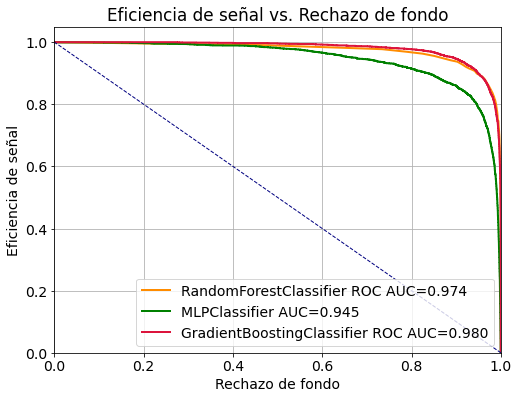

In [10]:
plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, rf_prediccion_proba)
plt.plot(1-fpr, tpr, color='darkorange', lw=2,
         label='{} ROC AUC={:.3f}'.format(rf_nombre, roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, mlp_prediccion_proba)
plt.plot(1-fpr, tpr, color='green', lw=2,
         label='{} AUC={:.3f}'.format(mlp_nombre, roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, gb_prediccion_proba)
plt.plot(1-fpr, tpr, color='crimson', lw=2,
         label='{} ROC AUC={:.3f}'.format(gb_nombre, roc_auc))

plt.plot([1, 0], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Rechazo de fondo')
plt.ylabel('Eficiencia de señal')
plt.title('Eficiencia de señal vs. Rechazo de fondo')
plt.show()

<ipython-input-11-cff2728bf506>:6: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, 1/fpr, color='darkorange', lw=2,
<ipython-input-11-cff2728bf506>:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, 1/fpr, color='green', lw=2,
<ipython-input-11-cff2728bf506>:14: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, 1/fpr, color='crimson', lw=2,


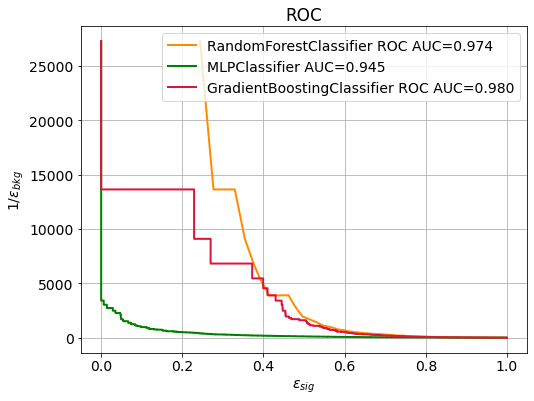

In [11]:
plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, rf_prediccion_proba)
plt.plot(tpr, 1/fpr, color='darkorange', lw=2,
         label='{} ROC AUC={:.3f}'.format(rf_nombre, roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, mlp_prediccion_proba)
plt.plot(tpr, 1/fpr, color='green', lw=2,
         label='{} AUC={:.3f}'.format(mlp_nombre, roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, gb_prediccion_proba)
plt.plot(tpr, 1/fpr, color='crimson', lw=2,
         label='{} ROC AUC={:.3f}'.format(gb_nombre, roc_auc))


plt.legend(loc="upper right")
plt.xlabel('$\epsilon_{sig}$')
plt.ylabel('$1/\epsilon_{bkg}$')
plt.title('ROC')
plt.show()

## Feature importance
Para cada algoritmo podemos obtener el peso de cada característica en la decisión:

In [12]:
#fi_mlp = mlp_clf.feature_importances_.tolist()
fi_rf = rf_clf.feature_importances_.tolist()
fi_gb = gb_clf.feature_importances_.tolist()

pesos = [fi_rf, fi_gb]
pesos = [[ round(elem, 3) for elem in peso ] for peso in pesos]
nombres = [rf_nombre, gb_nombre]
features = X_train.columns.tolist()

importancia = {}
ii = 0
for peso in pesos:
    f_i = list(zip(features, peso))
    importancia[nombres[ii]] = f_i
    ii +=1

In [13]:
for nombre in nombres:
    print(nombre)
    print('-'*120)
    print(importancia[nombre])
    print('-'*120)

RandomForestClassifier
------------------------------------------------------------------------------------------------------------------------
[('pT_j1', 0.055), ('m_j1', 0.124), ('eta_j1', 0.017), ('phi_j1', 0.018), ('E_j1', 0.024), ('tau_21_j1', 0.076), ('nhadrones_j1', 0.042), ('pT_j2', 0.082), ('m_j2', 0.095), ('eta_j2', 0.018), ('phi_j2', 0.018), ('E_j2', 0.026), ('tau_21_j2', 0.065), ('nhadrones_j2', 0.043), ('m_jj', 0.139), ('deltaR_j12', 0.039), ('n_hadrones', 0.119)]
------------------------------------------------------------------------------------------------------------------------
GradientBoostingClassifier
------------------------------------------------------------------------------------------------------------------------
[('pT_j1', 0.041), ('m_j1', 0.088), ('eta_j1', 0.0), ('phi_j1', 0.0), ('E_j1', 0.001), ('tau_21_j1', 0.062), ('nhadrones_j1', 0.002), ('pT_j2', 0.058), ('m_j2', 0.057), ('eta_j2', 0.0), ('phi_j2', 0.0), ('E_j2', 0.0), ('tau_21_j2', 0.045), ('nhadron

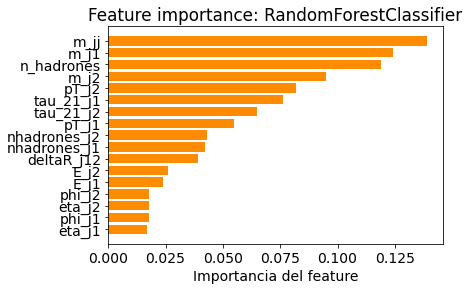

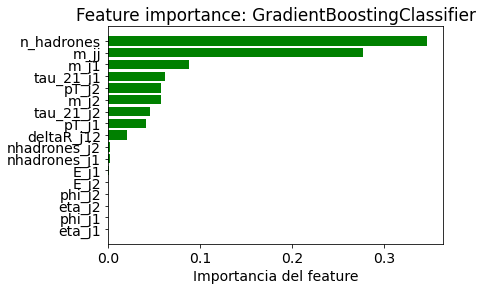

In [14]:
import numpy as np
import matplotlib.pyplot as plt
 
colores = ['darkorange', 'green', 'crimson']    
ii = 0
for nombre, scores in importancia.items():

    # Ordenamos de menor a mayor
    scores.sort(key=lambda x: x[1], reverse=False) 

    # Salvamos los nombres y su puntaje separados
    # y revertimos las tuplas para tener de mayor a menor puntaje  
    features = list(zip(*scores))[0]
    score = list(zip(*scores))[1]
    x_pos = np.arange(len(features)) 

    # Graficamos
    plt.barh(x_pos, score,align='center', color = colores[ii])
    plt.yticks(x_pos, features) 
    plt.xlabel('Importancia del feature')
    plt.title('Feature importance: {}'.format(nombre))
    plt.show()
    ii += 1

Notamos que en ambos casos la masa invariante y la masa del jet principal y secundario son características que el algoritmo considera importantes. 
Multilayer Perceptron no posee un método para obtener la importancia de las características.

## Clasificación libre de modelo
Hasta ahora hicimos las clasificación con los datos de la masa invariante. Sin embargo, es de interés lograr una clasificación libre de modelo, por lo que volveremos a correr el mismo código pero sin los datos de masa

In [15]:
# Separamos los datos en conjuntos de entrenamiento y prueba
X, y = data_ready(df_RD)
X = X.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
X.head()

,pT_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrones_j1,pT_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrones_j2,deltaR_j12,n_hadrones
8511,1636.540865,0.224496,-2.373993,1729.163350,0.371356,118,1547.619954,1.162014,0.710714,2722.719214,0.377317,59,3.224028,228.0
36440,1700.570450,-1.046567,-0.074009,2722.693611,0.173263,20,1471.042986,-0.496909,-3.102066,1660.217227,0.931903,39,3.077540,89.0
8950,1209.240264,1.501579,3.008941,2849.555797,0.693441,20,1192.250774,1.114281,-0.051151,2015.636945,0.527644,33,3.084503,86.0
49697,1331.228201,0.991312,2.934796,2041.150095,0.746076,13,1206.745736,0.501046,-0.197147,1366.214578,0.967665,54,3.170083,122.0
45480,1229.918669,-0.947064,2.870159,1828.159257,0.918211,39,1226.020830,0.063516,-0.261698,1238.924198,0.873326,42,3.290866,109.0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% entrenamiento y 30% prueba

C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression
****Resultados****
Precisión: 71.6552%
Pérdida logaritmica: 0.1789
              precision    recall  f1-score   support

       fondo       0.94      0.98      0.96     27297
       señal       0.72      0.38      0.50      2703

    accuracy                           0.93     30000
   macro avg       0.83      0.68      0.73     30000
weighted avg       0.92      0.93      0.92     30000



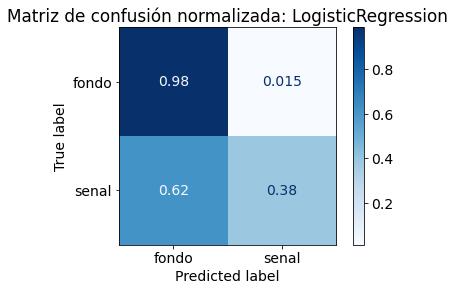

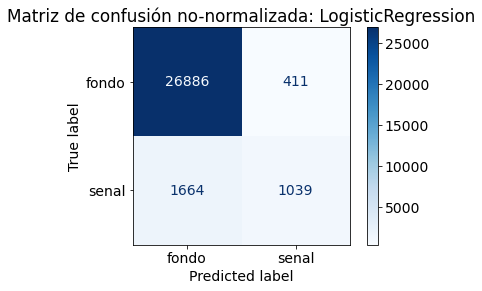

KNeighborsClassifier
****Resultados****
Precisión: 49.1384%
Pérdida logaritmica: 1.386
              precision    recall  f1-score   support

       fondo       0.94      0.96      0.95     27297
       señal       0.49      0.37      0.42      2703

    accuracy                           0.91     30000
   macro avg       0.72      0.67      0.69     30000
weighted avg       0.90      0.91      0.90     30000



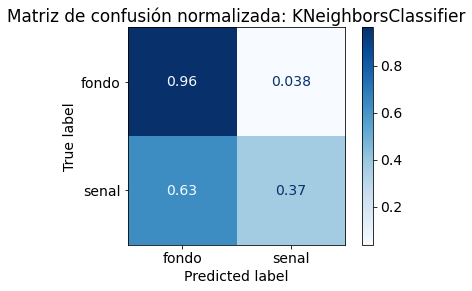

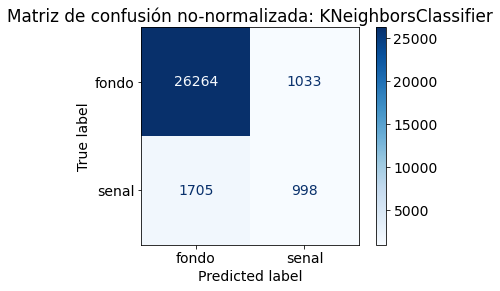

SVC
****Resultados****


C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.p

Precisión: 0.0000%
Pérdida logaritmica: 0.2643
              precision    recall  f1-score   support

       fondo       0.91      1.00      0.95     27297
       señal       0.00      0.00      0.00      2703

    accuracy                           0.91     30000
   macro avg       0.45      0.50      0.48     30000
weighted avg       0.83      0.91      0.87     30000



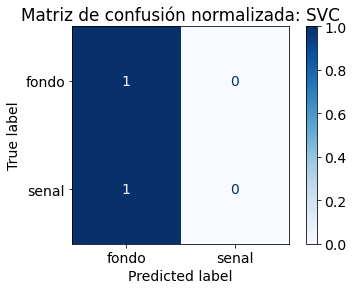

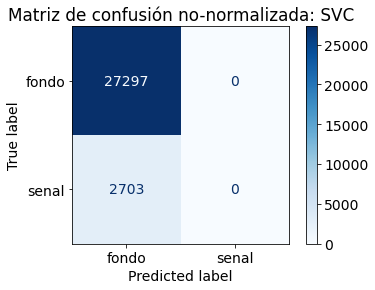

DecisionTreeClassifier
****Resultados****
Precisión: 61.6446%
Pérdida logaritmica: 0.1987
              precision    recall  f1-score   support

       fondo       0.94      0.97      0.96     27297
       señal       0.62      0.41      0.49      2703

    accuracy                           0.92     30000
   macro avg       0.78      0.69      0.73     30000
weighted avg       0.91      0.92      0.92     30000



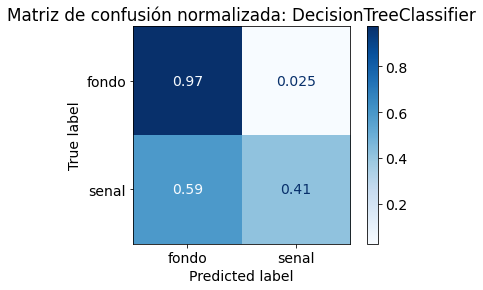

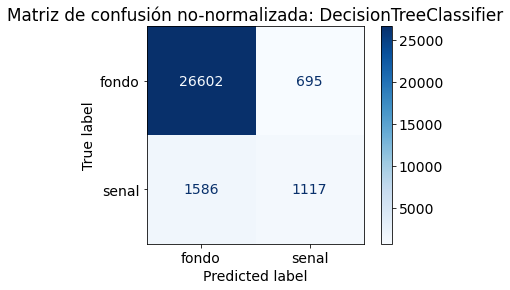

RandomForestClassifier
****Resultados****
Precisión: 85.8393%
Pérdida logaritmica: 0.1589
              precision    recall  f1-score   support

       fondo       0.96      0.99      0.97     27297
       señal       0.86      0.58      0.69      2703

    accuracy                           0.95     30000
   macro avg       0.91      0.79      0.83     30000
weighted avg       0.95      0.95      0.95     30000



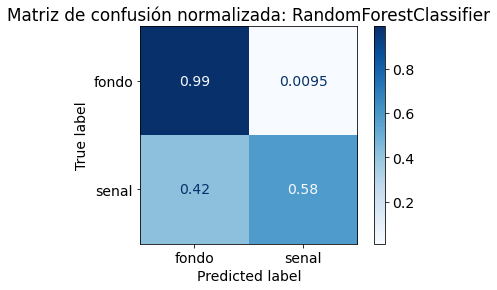

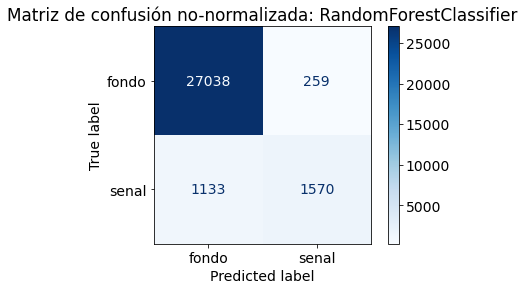

AdaBoostClassifier
****Resultados****
Precisión: 71.8277%
Pérdida logaritmica: 0.6493
              precision    recall  f1-score   support

       fondo       0.96      0.98      0.97     27297
       señal       0.72      0.56      0.63      2703

    accuracy                           0.94     30000
   macro avg       0.84      0.77      0.80     30000
weighted avg       0.94      0.94      0.94     30000



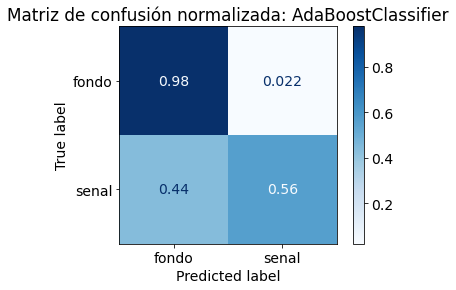

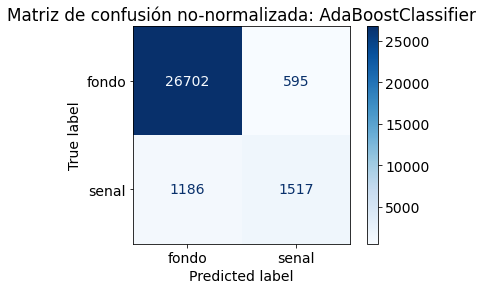

GradientBoostingClassifier
****Resultados****
Precisión: 80.5948%
Pérdida logaritmica: 0.1346
              precision    recall  f1-score   support

       fondo       0.96      0.99      0.97     27297
       señal       0.81      0.59      0.68      2703

    accuracy                           0.95     30000
   macro avg       0.88      0.79      0.83     30000
weighted avg       0.95      0.95      0.95     30000



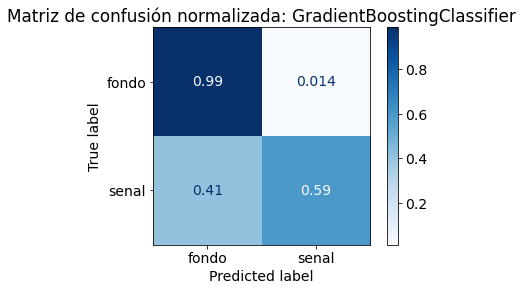

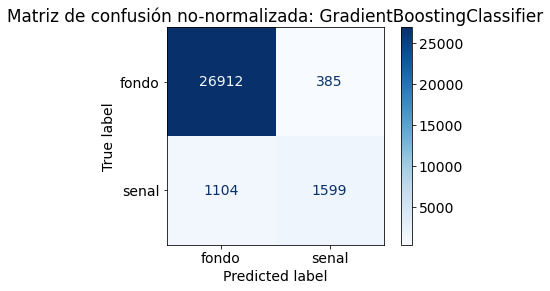

GaussianNB
****Resultados****
Precisión: 53.4932%
Pérdida logaritmica: 0.236
              precision    recall  f1-score   support

       fondo       0.97      0.94      0.95     27297
       señal       0.53      0.67      0.59      2703

    accuracy                           0.92     30000
   macro avg       0.75      0.81      0.77     30000
weighted avg       0.93      0.92      0.92     30000



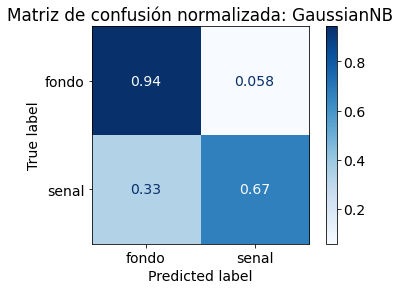

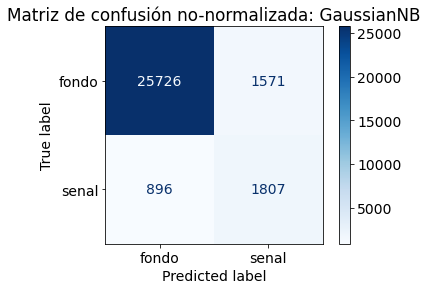

LinearDiscriminantAnalysis
****Resultados****
Precisión: 66.5298%
Pérdida logaritmica: 0.1802
              precision    recall  f1-score   support

       fondo       0.95      0.98      0.96     27297
       señal       0.67      0.48      0.56      2703

    accuracy                           0.93     30000
   macro avg       0.81      0.73      0.76     30000
weighted avg       0.92      0.93      0.93     30000



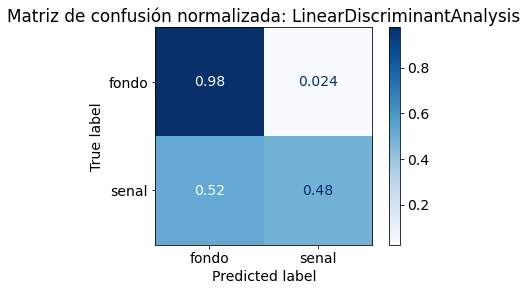

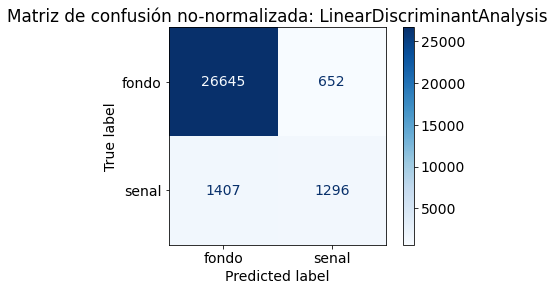

QuadraticDiscriminantAnalysis
****Resultados****
Precisión: 68.8486%
Pérdida logaritmica: 0.1642
              precision    recall  f1-score   support

       fondo       0.97      0.97      0.97     27297
       señal       0.69      0.65      0.67      2703

    accuracy                           0.94     30000
   macro avg       0.83      0.81      0.82     30000
weighted avg       0.94      0.94      0.94     30000



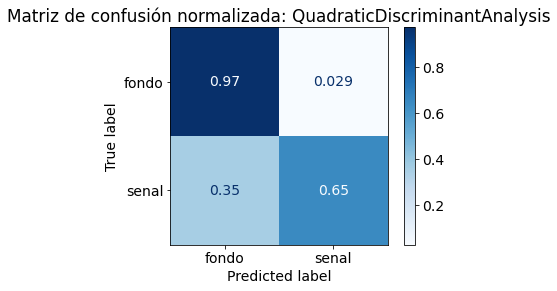

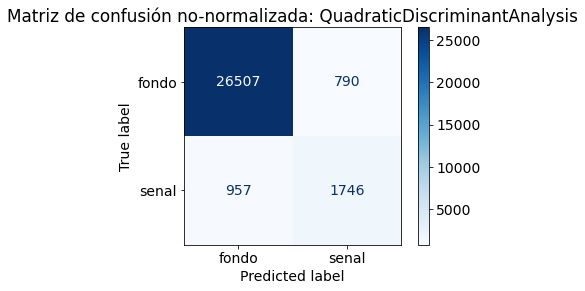

MLPClassifier
****Resultados****
Precisión: 0.0000%
Pérdida logaritmica: 0.5759
              precision    recall  f1-score   support

       fondo       0.91      1.00      0.95     27297
       señal       0.00      0.00      0.00      2703

    accuracy                           0.91     30000
   macro avg       0.45      0.50      0.48     30000
weighted avg       0.83      0.91      0.87     30000



C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.p

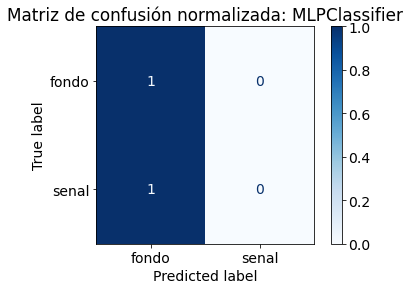

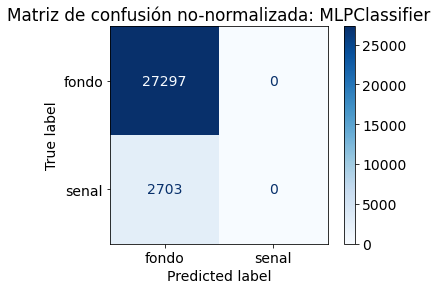

In [17]:
# Importamos las métricas a utilizar
from sklearn.metrics import precision_score, log_loss, recall_score, plot_confusion_matrix,classification_report, f1_score

# Importamos los clasificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier



# Listamos los clasificadores a comparar
clasificadores = [LogisticRegression(max_iter=600),
                KNeighborsClassifier(3, weights='distance'),
                SVC(kernel="rbf", C=0.025, probability=True),
                DecisionTreeClassifier(criterion="entropy", max_depth=3),
                RandomForestClassifier(),
                AdaBoostClassifier(),
                GradientBoostingClassifier(),
                GaussianNB(),
                LinearDiscriminantAnalysis(),
                QuadraticDiscriminantAnalysis(), 
                MLPClassifier()]

# Registro para comparación visual
log_cols=["Clasificador", "Precision", "Perdida Log", "puntaje f1"]
log = pd.DataFrame(columns=log_cols)

for clf in clasificadores:
    
    # Entrenamos el clasificador y obtenemos su nombre
    clf.fit(X_train, y_train)
    nombre = clf.__class__.__name__
    
    print("="*30)
    print(nombre)
    
    print('****Resultados****')
    
    # Obtenemos las predicciones
    y_pre = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    # Calculamos algunas métricas
    precision = precision_score(y_test, y_pre)
    print("Precisión: {:.4%}".format(precision))
    
    ll = log_loss(y_test, y_proba)
    print("Pérdida logaritmica: {:.4}".format(ll))
    
    f1 = f1_score(y_test, y_pre)
    
    # Imprimimos el reporte general
    print(classification_report(y_test, y_pre, target_names=['fondo','señal']))
    
    # Insertamos los datos en el dataframe
    log_entry = pd.DataFrame([[nombre, precision*100, ll, f1]], columns=log_cols)
    log = log.append(log_entry)
    
    # Graficamos la matriz de confusión
    
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['fondo','senal'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    
    disp.ax_.set_title("Matriz de confusión normalizada: {}".format(nombre))

    plt.show()
    
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['fondo','senal'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    
    disp.ax_.set_title("Matriz de confusión no-normalizada: {}".format(nombre))

    plt.show()
    
print("="*30)

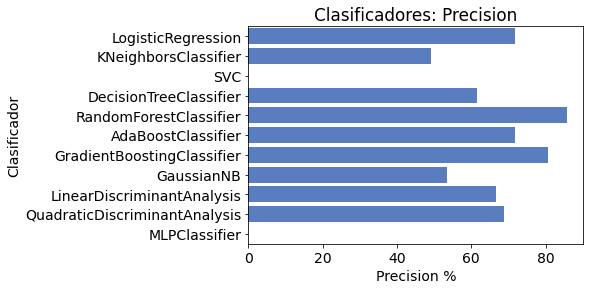

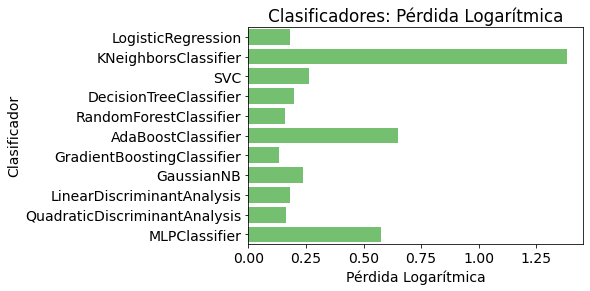

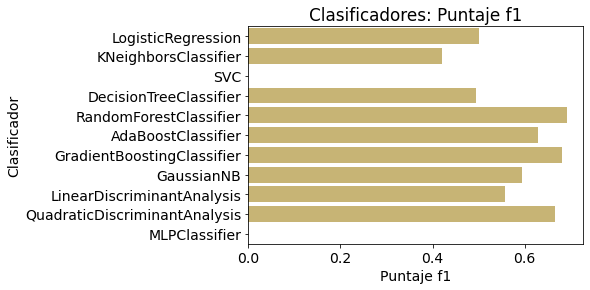

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Clasificador', data=log, color="b")
plt.xlabel('Precision %')
plt.title('Clasificadores: Precision')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Perdida Log', y='Clasificador', data=log, color="g")
plt.xlabel('Pérdida Logarítmica')
plt.title('Clasificadores: Pérdida Logarítmica')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='puntaje f1', y='Clasificador', data=log, color="y")
plt.xlabel('Puntaje f1')
plt.title('Clasificadores: Puntaje f1')
plt.show()

In [19]:
# https://stackoverflow.com/questions/52373318/how-to-compare-roc-auc-scores-of-different-binary-classifiers-and-assess-statist
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib

#MLP Classifier
mlp_clf = MLPClassifier(max_iter=400)
mlp_clf.fit(X_train, y_train)
mlp_prediccion_proba = mlp_clf.predict_proba(X_test)[:, 1]
mlp_nombre = mlp_clf.__class__.__name__


# Random Forest 
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_prediccion_proba = rf_clf.predict_proba(X_test)[:, 1]
rf_nombre = rf_clf.__class__.__name__

# Gradient Boosting
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
gb_prediccion_proba = gb_clf.predict_proba(X_test)[:, 1]
gb_nombre = gb_clf.__class__.__name__

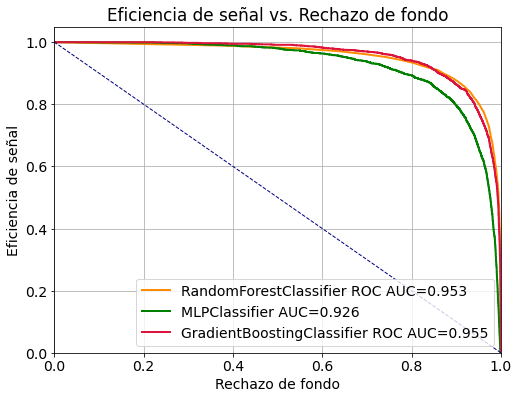

In [20]:
plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, rf_prediccion_proba)
plt.plot(1-fpr, tpr, color='darkorange', lw=2,
         label='{} ROC AUC={:.3f}'.format(rf_nombre, roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, mlp_prediccion_proba)
plt.plot(1-fpr, tpr, color='green', lw=2,
         label='{} AUC={:.3f}'.format(mlp_nombre, roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, gb_prediccion_proba)
plt.plot(1-fpr, tpr, color='crimson', lw=2,
         label='{} ROC AUC={:.3f}'.format(gb_nombre, roc_auc))

plt.plot([1, 0], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Rechazo de fondo')
plt.ylabel('Eficiencia de señal')
plt.title('Eficiencia de señal vs. Rechazo de fondo')
plt.show()

<ipython-input-21-cff2728bf506>:6: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, 1/fpr, color='darkorange', lw=2,
<ipython-input-21-cff2728bf506>:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, 1/fpr, color='green', lw=2,
<ipython-input-21-cff2728bf506>:14: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, 1/fpr, color='crimson', lw=2,


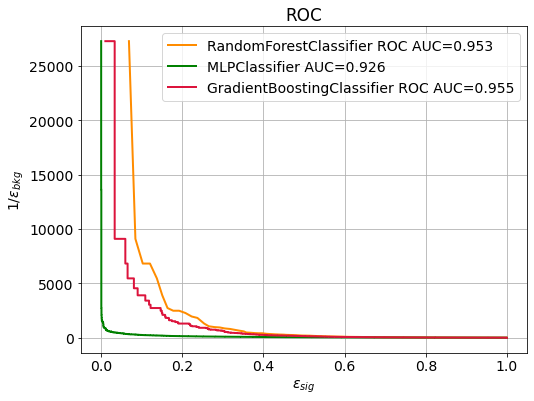

In [21]:
plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, rf_prediccion_proba)
plt.plot(tpr, 1/fpr, color='darkorange', lw=2,
         label='{} ROC AUC={:.3f}'.format(rf_nombre, roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, mlp_prediccion_proba)
plt.plot(tpr, 1/fpr, color='green', lw=2,
         label='{} AUC={:.3f}'.format(mlp_nombre, roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, gb_prediccion_proba)
plt.plot(tpr, 1/fpr, color='crimson', lw=2,
         label='{} ROC AUC={:.3f}'.format(gb_nombre, roc_auc))


plt.legend(loc="upper right")
plt.xlabel('$\epsilon_{sig}$')
plt.ylabel('$1/\epsilon_{bkg}$')
plt.title('ROC')
plt.show()

In [22]:
#fi_mlp = mlp_clf.feature_importances_.tolist()
fi_rf = rf_clf.feature_importances_.tolist()
fi_gb = gb_clf.feature_importances_.tolist()

pesos = [fi_rf, fi_gb]
pesos = [[ round(elem, 3) for elem in peso ] for peso in pesos]
nombres = [rf_nombre, gb_nombre]
features = X_train.columns.tolist()

importancia = {}
ii = 0
for peso in pesos:
    f_i = list(zip(features, peso))
    importancia[nombres[ii]] = f_i
    ii +=1

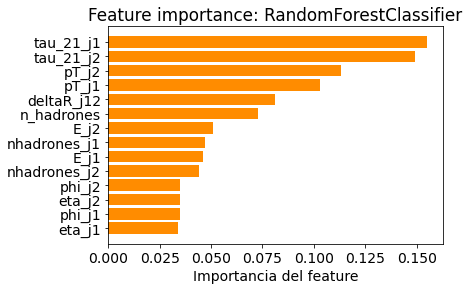

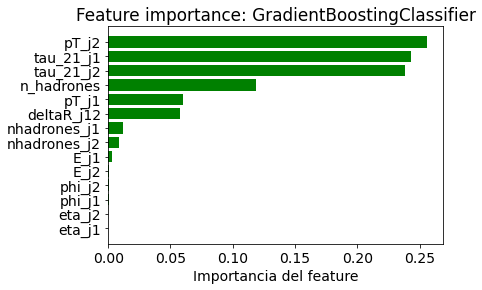

In [23]:
import numpy as np
import matplotlib.pyplot as plt
 
colores = ['darkorange', 'green', 'crimson']    
ii = 0
for nombre, scores in importancia.items():

    # Ordenamos de menor a mayor
    scores.sort(key=lambda x: x[1], reverse=False) 

    # Salvamos los nombres y su puntaje separados
    # y revertimos las tuplas para tener de mayor a menor puntaje  
    features = list(zip(*scores))[0]
    score = list(zip(*scores))[1]
    x_pos = np.arange(len(features)) 

    # Graficamos
    plt.barh(x_pos, score,align='center', color = colores[ii])
    plt.yticks(x_pos, features) 
    plt.xlabel('Importancia del feature')
    plt.title('Feature importance: {}'.format(nombre))
    plt.show()
    ii += 1

Al eliminar las masas, vemos que el modelo se basa más en el pT de los jets, el número de hadrones y la variable de subestructura tau para clasificar los eventos.

## En BB1
Podemos probar estos clasificadores en la BB1:

In [24]:
# Importamos los datos
datos = ['../data/datosBB1_0', '../data/datosBB1_1', '../data/datosBB1_2', '../data/datosBB1_3', '../data/datosBB1_4',
        '../data/datosBB1_5', '../data/datosBB1_6', '../data/datosBB1_7', '../data/datosBB1_8', '../data/datosBB1_9']
df_bb = pd.DataFrame()

for path in datos:
    df_i = pd.read_csv(path)
    df_bb = pd.concat([df_bb, df_i])

df_bb.shape

(512000, 18)

In [25]:
# Preparamos los datos
df_bb = df_bb.sample(100000, random_state=5)
X_test, y_test = data_ready(df_bb)

X_test = X_test.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)

RandomForestClassifier
****Resultados****
Precisión: 2.7910%
Pérdida logaritmica: 0.08225
              precision    recall  f1-score   support

       fondo       1.00      0.99      0.99     99917
       señal       0.03      0.49      0.05        83

    accuracy                           0.99    100000
   macro avg       0.51      0.74      0.52    100000
weighted avg       1.00      0.99      0.99    100000



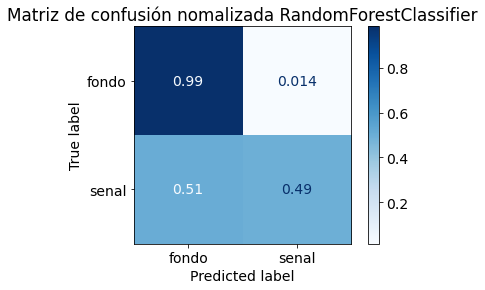

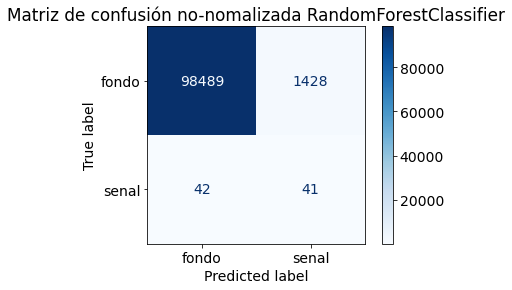

MLPClassifier
****Resultados****
Precisión: 0.4260%
Pérdida logaritmica: 0.4603
              precision    recall  f1-score   support

       fondo       1.00      0.84      0.91     99917
       señal       0.00      0.81      0.01        83

    accuracy                           0.84    100000
   macro avg       0.50      0.83      0.46    100000
weighted avg       1.00      0.84      0.91    100000



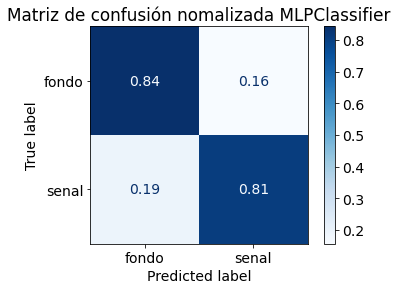

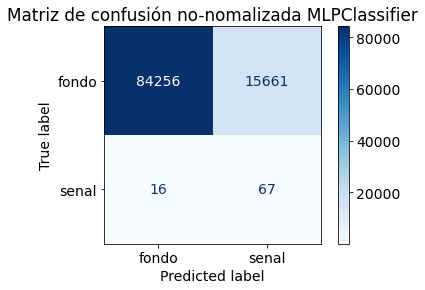

GradientBoostingClassifier
****Resultados****
Precisión: 2.2107%
Pérdida logaritmica: 0.07287
              precision    recall  f1-score   support

       fondo       1.00      0.98      0.99     99917
       señal       0.02      0.57      0.04        83

    accuracy                           0.98    100000
   macro avg       0.51      0.77      0.52    100000
weighted avg       1.00      0.98      0.99    100000



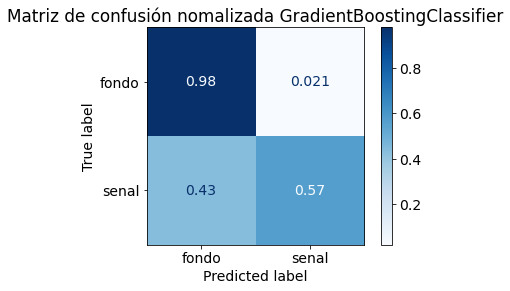

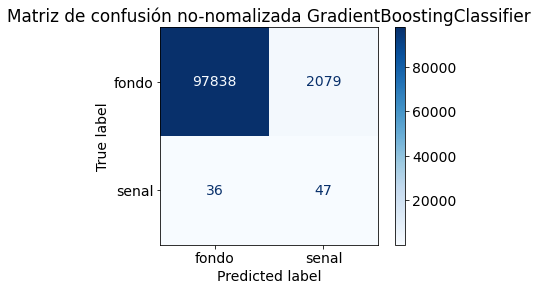

In [26]:
# Listamos los clasificadores a comparar
clasificadores = [RandomForestClassifier(),
                MLPClassifier(max_iter=400),
                GradientBoostingClassifier(),]

# Registro para comparación visual
log_cols=["Clasificador", "Precision", "Perdida Log", "puntaje f1"]
log = pd.DataFrame(columns=log_cols)

for clf in clasificadores:
    
    # Entrenamos el clasificador y obtenemos su nombre
    clf.fit(X_train, y_train)
    nombre = clf.__class__.__name__
    
    print("="*30)
    print(nombre)
    
    print('****Resultados****')
    
    # Obtenemos las predicciones
    y_pre = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    # Calculamos algunas métricas
    precision = precision_score(y_test, y_pre)
    print("Precisión: {:.4%}".format(precision))
    
    ll = log_loss(y_test, y_proba)
    print("Pérdida logaritmica: {:.4}".format(ll))
    
    f1 = f1_score(y_test, y_pre)
    
    # Imprimimos el reporte general
    print(classification_report(y_test, y_pre, target_names=['fondo','señal']))
    
    # Insertamos los datos en el dataframe
    log_entry = pd.DataFrame([[nombre, precision*100, ll, f1]], columns=log_cols)
    log = log.append(log_entry)
    
    # Graficamos la matriz de confusión
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['fondo','senal'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    
    disp.ax_.set_title("Matriz de confusión nomalizada {}".format(nombre))

    plt.show()
    
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['fondo','senal'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    
    disp.ax_.set_title("Matriz de confusión no-nomalizada {}".format(nombre))

    plt.show()
    
print("="*30)

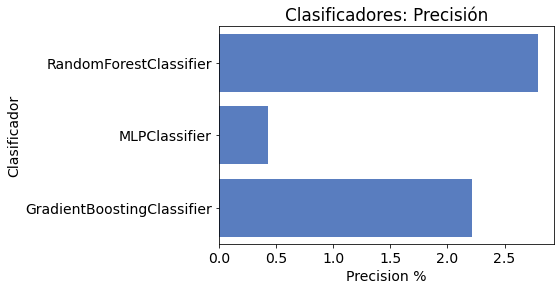

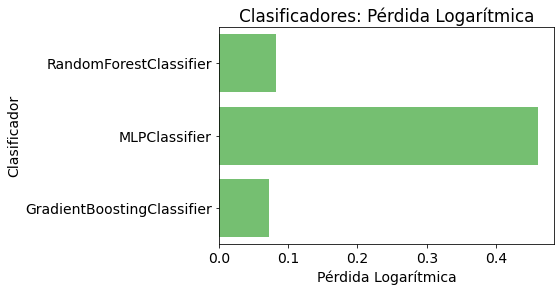

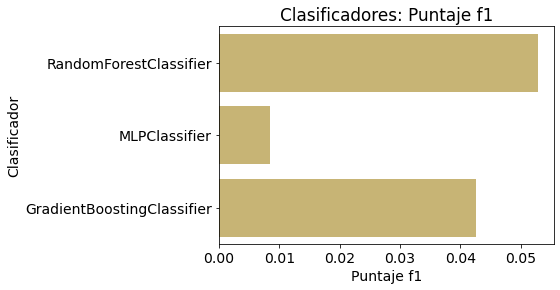

In [27]:
sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Clasificador', data=log, color="b")
plt.xlabel('Precision %')
plt.title('Clasificadores: Precisión')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Perdida Log', y='Clasificador', data=log, color="g")
plt.xlabel('Pérdida Logarítmica')
plt.title('Clasificadores: Pérdida Logarítmica')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='puntaje f1', y='Clasificador', data=log, color="y")
plt.xlabel('Puntaje f1')
plt.title('Clasificadores: Puntaje f1')
plt.show()